### Importing Libraries

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import cv2
import os

C:\Users\akshay\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


### Loading and Visualising Data

#### Using only 100 images due to hardware constraint

In [2]:
image_path = './train_val/images/'
mask_path = './train_val/masks/'

def load_data():
    X = []
    y = []
    files_img = os.listdir(image_path)
    files_mask = os.listdir(mask_path)
    
    for i in range(100):
        image = cv2.imread(image_path + files_img[i])
        mask = cv2.imread(mask_path + files_mask[i])
        X.append(image)
        y.append(mask)
        
    return (np.array(X), np.array(y))

In [3]:
(images, masks) = load_data()

C:\Users\akshay\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [4]:
def visualise_data(X, y):
    # selecting random indices
    indices = np.random.randint(0, len(y)-1, 5)
    columns = 2
    rows = 5
    fig = plt.figure(figsize = (6, 15))
    j = 0
    for i in range(1, columns*rows +1, 2):
        image = cv2.cvtColor(X[indices[j]], cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(y[indices[j]], cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
        plt.axis('off')
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(mask)
        plt.axis('off')
        j += 1
    plt.show()

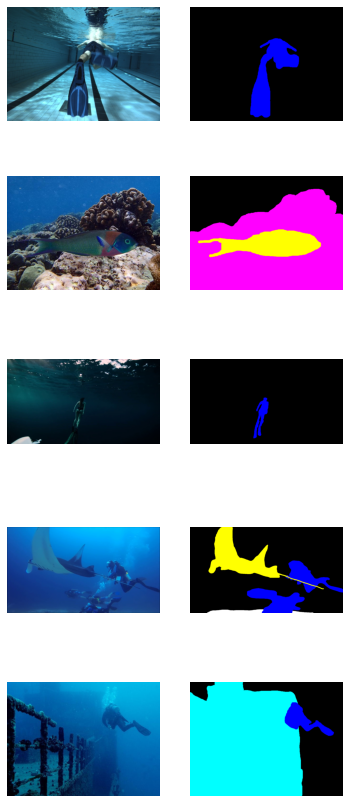

In [5]:
visualise_data(images, masks)

### Data Processing

In [6]:
## Let us see shapes of our images
sizes_image = dict()
for x in images:
    try:
        sizes_image[x.shape] += 1
    except:
        sizes_image[x.shape] = 1
        
sizes_image

{(480, 640, 3): 36,
 (720, 1280, 3): 24,
 (448, 480, 3): 6,
 (720, 1152, 3): 2,
 (1080, 1906, 3): 7,
 (360, 640, 3): 4,
 (480, 584, 3): 4,
 (540, 960, 3): 9,
 (600, 800, 3): 6,
 (960, 1280, 3): 1,
 (416, 416, 3): 1}

In [7]:
## We need to resize input images to shape (572, 572, 3)

In [8]:
def preprocess(X, y):
    # input images must be of shape (572, 572, 3)
    for i in range(len(X)):
        X[i] = cv2.resize(X[i], (572, 572)) # resizing input image as in paper
        y[i] = cv2.resize(y[i], (388, 388)) # resizing mask as in paper
        
    # Now due to resizing our mask may contain values other than 0 and 255
    # so binarizing 
    for i in range(len(y)):
        y[i] = np.where(y[i] > 127, 255, 0) # if pixel value is > 255/2 we say 255 else 0
        
    # Now we need to convert RGB masks into 8 channels
    # All possible 8 channels are
    # [(0, 0, 0), (0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255)]
    # Storing all possible channels in a map
    mp = {
        (0, 0, 0):0, (0, 0, 255):1, (0, 255, 0):2, (255, 0, 0):3, (0, 255, 255):4, (255, 0, 255):5, (255, 255, 0):6, (255, 255, 255):7
    }
    
    y_final = np.zeros((len(y), 388, 388, 8))
    
    for i in range(len(y)):
        for r in range(388):
            for c in range(388):
                y_final[i][r][c][mp[tuple(y[i][r][c])]] = 1
        
    return (np.stack(X), np.array(y_final))
        

In [9]:
X, y = preprocess(images, masks)

### Now X is the input and y is our desired output

In [10]:
y.shape

(100, 388, 388, 8)

In [11]:
X.shape

(100, 572, 572, 3)

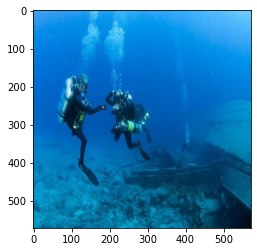

In [12]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

In [13]:
# These dict will help us to convert our output to images
mp = {(0, 0, 0):0, (0, 0, 255):1, (0, 255, 0):2, (255, 0, 0):3, (0, 255, 255):4, (255, 0, 255):5, (255, 255, 0):6, (255, 255, 255):7}
rmp = {} # reverse map

for key, val in mp.items():
    rmp[val] = key

### Normalizing the data and then splitting into train and validation sets

In [14]:
X = X/255. # Normalising the pixel values

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=69)

In [15]:
### Reshaping arrays as expected by torch
X_train = X_train.reshape((-1, 3, 572, 572))
X_val = X_val.reshape((-1, 3, 572, 572))
y_train = y_train.reshape((-1, 8, 388, 388))
y_val = y_val.reshape((-1, 8, 388, 388))

X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [16]:
X_train.shape

torch.Size([80, 3, 572, 572])

### Now that we have got the data we build the Unet model as in paper
https://arxiv.org/pdf/1505.04597.pdf
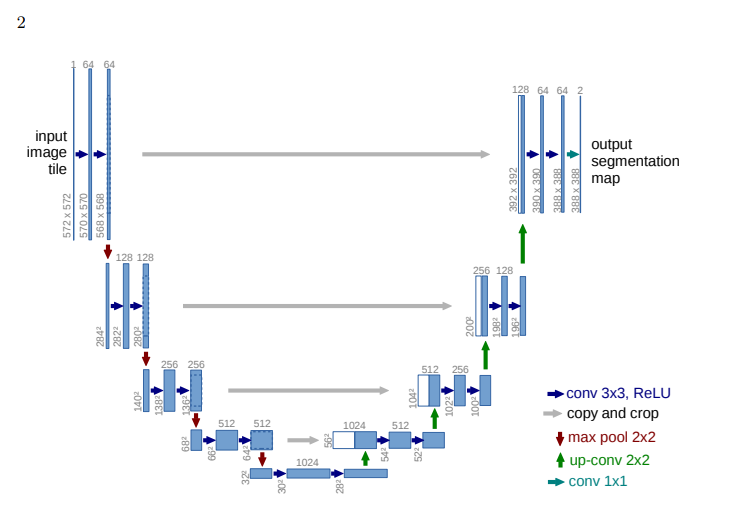

In [17]:
# We see in every step of the network we have compulsarily two convolution layers hence lets create a class for it

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 0),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 0),
            nn.ReLU(inplace = True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
    
class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the UNET (down part)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Decoder part of the UNET (up part)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(2*feature, feature, kernel_size=2, stride = 2))
            self.ups.append(DoubleConv(2*feature, feature))
            
        # bottom most part of UNET
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # output of the decoder block 8 channel output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    
    def forward(self, x):
        # Now that we have all the blocks required to build UNET 
        # We now define a forward function
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        # bottle neck layer
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # building up
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] 
            
            # Resizing the skip_connection
            if x.shape != skip_connection.shape:
                skip_connection = TF.resize(skip_connection, size = x.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim = 1) # concat along channels
            x = self.ups[idx+1](concat_skip) # Double Conv
            
        return self.final_conv(x)


In [32]:
# Now let us see if we have got our expected output shape or not
def test():
    x = torch.randn((3, 3, 572, 572))
    model = UNET(in_channels = 3, out_channels = 8)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
test()

torch.Size([3, 8, 388, 388])
torch.Size([3, 3, 572, 572])


### Training

In [18]:
use_gpu = torch.cuda.is_available()
model = UNET(in_channels=3, out_channels=8)

# if use_gpu:
#     print('GPU is avaialble!')
#     model = model.cuda()

In [19]:
print(model)

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (4): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (5): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
      )
  

In [20]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # ADAM 
num_epochs = 50
batch_size = 8

In [21]:
def train(epoch):
    model.train()
    tr_loss = 0
    
    # getting the training set
    x_train, ytrain = Variable(X_train), Variable(y_train)
    
    # getting the validation set
    x_val, yval = Variable(X_val), Variable(y_val)
    
    # converting the data into GPU format
#     if torch.cuda.is_available():
#         x_train = x_train.cuda()
#         ytrain = ytrain.cuda()
#         x_val = x_val.cuda()
#         yval = yval.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.float())
    output_val = model(x_val.float())

    # computing the training and validation loss
    loss_train = criterion(output_train, ytrain)
    loss_val = criterion(output_val, yval)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [24]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1258815488 bytes.

#### Unable to perform further steps due to hardware constraint

### Interesting Point
The masks are RGB with pixel values either 0 or 255, so for 3 channels we can have 8 total combinations that are

(0, 0, 0), (0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 0, 255), (255, 255, 0), (255, 255, 255)

Hence with **RGB mask we can only perform segmentation upto 8 classes.**

So we can generalise for n channeled mask we can perform segmentation of upto 2^n classes.
